## Define problem instance

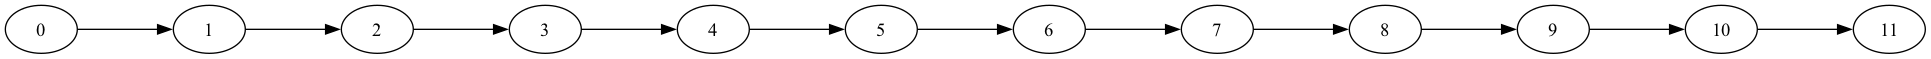

In [1]:
%load_ext autoreload
%autoreload 2

from qiskit.synthesis import LieTrotter
from qiskit.transpiler import CouplingMap
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit
from rustworkx.visualization import graphviz_draw

# L := length of our 1D spin chain
L = 12

# Generate the edge-list for this spin-chain
elist = [(i-1,i) for i in range(1, L)]
# Generate an edge-coloring so we can make hw-efficient circuits
red_edges  = elist[::2] 
blue_edges = elist[1::2]

# Instantiate a CouplingMap object
coupling_map = CouplingMap(elist)
graphviz_draw(coupling_map.graph, method="circo")

#### Generate the hamiltonian describing the transverse-field Ising model on a 10 qubit spin chain and construct the corresponding circuit

In [2]:
hamiltonian = SparsePauliOp(Pauli('I'*L))

import numpy as np
np.random.seed(0)
Js = np.random.rand(L-1) + 0.5*np.ones(L-1)

for i, edge in enumerate(red_edges + blue_edges):
    Ji = Js[i]   
    hamiltonian += SparsePauliOp.from_sparse_list(
    [("XX", (edge), Ji/2),
     ("YY", (edge), Ji/2),
     ("ZZ", (edge), Ji)], 
    num_qubits=L)


### Use MPF qiskit addon to generate coefficients of Trotter circuits

In [3]:
from qiskit_addon_mpf.static import setup_lse


mpf_trotter_steps = [3,4,7]
trotter_steps_total = mpf_trotter_steps + [100]
lse = setup_lse(mpf_trotter_steps, order=1, symmetric=False)
mpf_coeffs = lse.solve()
print(f"The coefficients associated with the ansatze are: {mpf_coeffs}")

The coefficients associated with the ansatze are: [ 2.25       -5.33333333  4.08333333]


### Construct each of the Trotter circuits

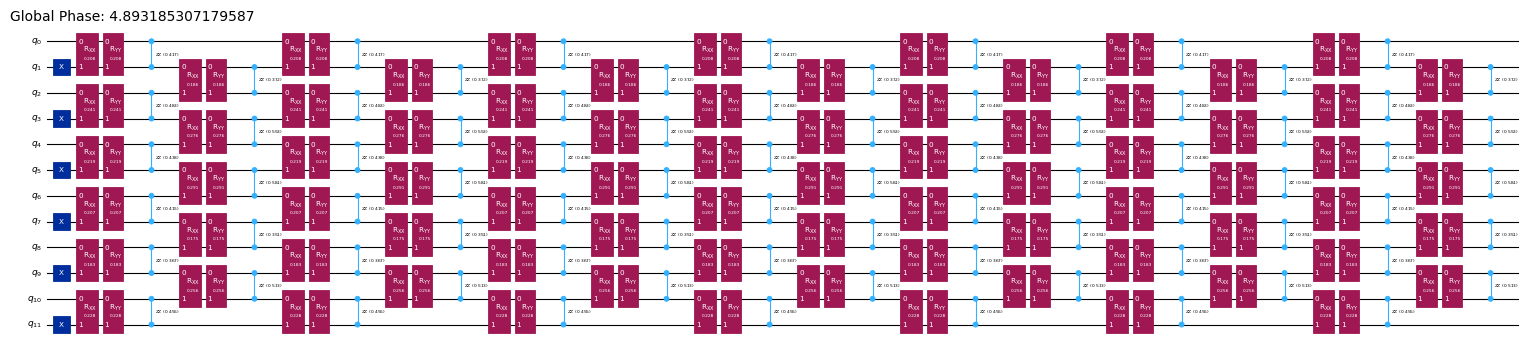

In [4]:
from qiskit import QuantumCircuit

# make initial state
initial_state = QuantumCircuit(L)
for i in range(L):
    if i%2:
        initial_state.x(i)

all_total_times = np.arange(0.1, 1.4, 0.01)

all_circs = []
for total_time in all_total_times:
    mpf_trotter_circs = [
        generate_time_evolution_circuit(
            hamiltonian,
            time=total_time,
            synthesis=LieTrotter(reps=num_steps),
        ) 
        for num_steps in trotter_steps_total]
    
    mpf_circuits = [initial_state.compose(circuit)
                   for circuit in mpf_trotter_circs]
    all_circs.append(mpf_circuits)

num_qubits = hamiltonian.num_qubits

observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (L//2 - 1, L//2), 1.0)], num_qubits=num_qubits
)
mpf_circuits[-2].draw("mpl", fold = -1, scale = 0.4)

# Check error of trotter circuits and MPF state against 100 Trotter steps

#### Compute the statevectors of each Trotter circuit at each value of time

In [5]:
from copy import deepcopy
import qiskit_aer
from qiskit_aer import AerSimulator
from qiskit_aer.library import save_statevector
from demo_utils import get_pbar

pbar = get_pbar(len(all_total_times))
simulator = AerSimulator(method = 'statevector')
statevecs_all_times = []
for t, mpf_circuits in zip(all_total_times , all_circs):
    pbar.set_description(f"Processing time {t:.2f}")
    mpf_statevecs = []
    circuits = [deepcopy(circuit) for circuit in mpf_circuits]
    for circuit in circuits:
        circuit.save_statevector()
        res = simulator.run(circuit)
        sv = res.result().data()['statevector']
        mpf_statevecs.append(sv)
    statevecs_all_times.append(mpf_statevecs)
    pbar.update(1)
pbar.set_description(f"All times processed")
pbar.close()

All times processed: 100%|███████████████████████████████████| 130/130 [00:13<00:00, 9.83it/s]                                                                                                                                                       


#### Using the statevectors, compute the expvals of each trotter circuit, as well as the error between each state and the 100 qubit Trotter state

In [6]:
from demo_utils import get_mpf_rho, frob_distance

trotter_errors = [[] for _ in range(len(trotter_steps_total))]
trotter_expvals = [[] for _ in range(len(trotter_steps_total)+1)]

pbar = get_pbar(len(all_total_times))

for ti, time in enumerate(all_total_times):
    pbar.set_description(f"Processing time {time:.2f}")
    sv_ref = statevecs_all_times[ti][-1]
    rho_ref = sv_ref.to_operator()
    mpf_expvals = []
    for j, sv in enumerate(statevecs_all_times[ti][:-1]):
        error = frob_distance(rho_ref, sv.to_operator())
        trotter_errors[j].append(error)
        expval = np.real(sv.expectation_value(observable))
        trotter_expvals[j].append(expval)
        mpf_expvals.append(expval)

    ref_expval = np.real(sv_ref.expectation_value(observable))
    trotter_expvals[-2].append(ref_expval)
    
    mpf_rho = get_mpf_rho(statevecs_all_times[ti][:-1], mpf_coeffs)
    mpf_error = frob_distance(rho_ref, mpf_rho)
    mpf_expval = mpf_expvals@mpf_coeffs
    trotter_errors[-1].append(mpf_error)
    trotter_expvals[-1].append(mpf_expval)
    pbar.update(1)
pbar.set_description(f"All times processed")
pbar.close()

All times processed: 100%|███████████████████████████████████| 130/130 [01:45<00:00, 1.23it/s]                                                                                                                                                       


### Using runtime, simulate the expectation values with statistical noise

In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

# create a local service
local_service = QiskitRuntimeService(channel="local")

pbar = get_pbar(len(all_circs), label='Simulating Trotter Circuits')

noiseless_backend = local_service.backend("aer_simulator")
noiseless_estimator = Estimator(noiseless_backend)
all_expvals = []
for t, trotter_circuits in zip(all_total_times, all_circs):
    pbar.set_description(f"Processing time {t:.2f}")
    pub_circuits = trotter_circuits 
    pub_observables = ([observable] * len(all_total_times)) 
    pubs = zip(pub_circuits, pub_observables)
    noiseless_result = noiseless_estimator.run(pubs, precision=0.001).result()
    mpf_expvals = [pub_result.data.evs for pub_result in noiseless_result]
    all_expvals.append(mpf_expvals)
    pbar.update(1)
pbar.set_description(f"All circuits processed")
pbar.close()

all_expvals = np.array(all_expvals)

All circuits processed: 100%|███████████████████████████████████| 130/130 [16:41<00:00, 7.70s/it]                                                                                                                                                    


# Save simulation results to disk / Load saved results from disk

In [14]:
from demo_utils import dill_load, dill_dump
sim_results_save_path = f"L{L}/{'_'.join([str(k) for k in mpf_trotter_steps])}/sim_results.pkl"

dill_dump({'trotter_steps_total': trotter_steps_total,
           'all_total_times': all_total_times,
           'trotter_errors':trotter_errors,
           'trotter_expvals':trotter_expvals,
           'all_expvals': all_expvals},
          sim_results_save_path, 
          make_dirs=True)

sim_results = dill_load(sim_results_save_path)
trotter_steps_total = sim_results['trotter_steps_total']
all_total_times = sim_results['all_total_times']
trotter_errors = sim_results['trotter_errors']
trotter_expvals = sim_results['trotter_expvals']
all_expvals = sim_results['all_expvals']

### Plot the error of the prepared states wrt the 100 Trotter step state

Text(0.5, 1.0, 'Frobenius Distance to state with 100 Trotter Steps')

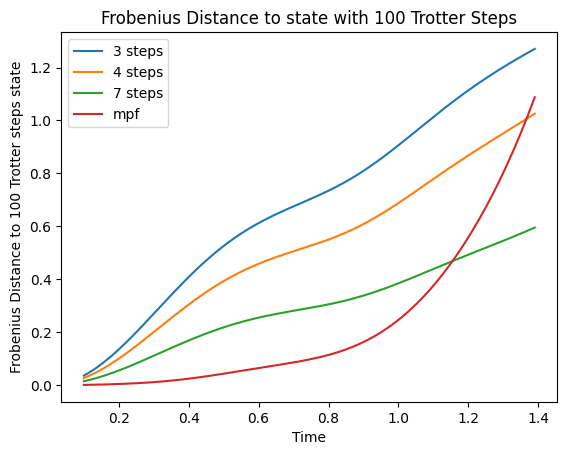

In [15]:
import matplotlib.pyplot as plt

for i, num_steps in enumerate(trotter_steps_total[:-1]):
    plt.plot(all_total_times, trotter_errors[i], label=f"{num_steps} steps")
plt.plot(all_total_times, trotter_errors[-1], label=f"mpf")
plt.legend()
plt.ylabel(f"Frobenius Distance to {trotter_steps_total[-1]} Trotter steps state")
plt.xlabel(f"Time")
plt.title(f"Frobenius Distance to state with {trotter_steps_total[-1]} Trotter Steps")

### Plot expectation values for exact simulations

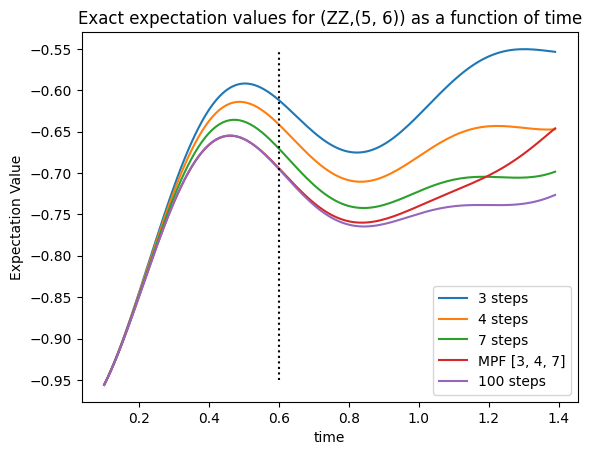

In [17]:
import matplotlib.pyplot as plt

for k,trotter_curve in enumerate(trotter_expvals[:-2]):
    plt.plot(all_total_times, trotter_curve, label=f"{trotter_steps_total[k]} steps")

plt.plot(all_total_times, trotter_expvals[-1], label=f'MPF {trotter_steps_total[:-1]}')
plt.plot(all_total_times, trotter_expvals[-2], label=f"{trotter_steps_total[-1]} steps")
plt.vlines(0.6, -0.95, -0.55, linestyle='dotted', color='black')
plt.title(f'Exact expectation values for (ZZ,{(L//2-1, L//2)}) as a function of time')
plt.xlabel('time')
plt.ylabel('Expectation Value')
plt.legend()

# Plot expectation values for simulations with statistical error

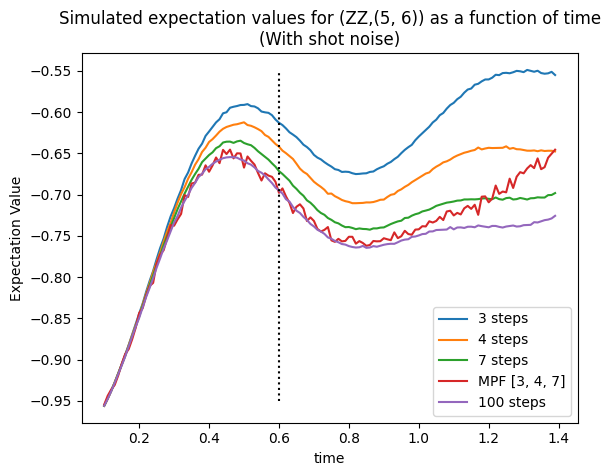

In [18]:
import matplotlib.pyplot as plt

all_trotter_curves = all_expvals.T
mpf_curve = all_expvals[:,:-1]@mpf_coeffs
for k,trotter_curve in enumerate(all_trotter_curves[:-1]):
    plt.plot(all_total_times, trotter_curve, label=f"{trotter_steps_total[k]} steps")

plt.plot(all_total_times, mpf_curve, label=f'MPF {trotter_steps_total[:-1]}')
plt.plot(all_total_times, all_trotter_curves[-1], label=f"{trotter_steps_total[-1]} steps")

plt.vlines(0.6, -0.95, -0.55, linestyle='dotted', color='black')
plt.title(f'Simulated expectation values for (ZZ,{(L//2-1, L//2)}) as a function of time\n(With shot noise)')
plt.xlabel('time')
plt.ylabel('Expectation Value')
plt.legend()